# Evaluation num epochs 60km -> 2.2km-4x over Birmingham

Compare STV models that have removed the scaling that assumes data is [0,1] or [-1,1] and moved to epoch-based training loop and shuffles the data over different number of epochs.

## Diff model

8-channels loc-spec params

Inputs:5 levels of spechum, temp and vorticity

Target domain and resolution: 64x64 2.2km-4x England and Wales
Input resolution: 60km/gcmx

Input transform: standardize (based on train set mean and std) then devide by standardized train set max

Target transform: sqrt then divide by sqrted train set max
Sample inverse transform: multiply by saved train set max, clip negative values to 0 then square

Input transforms are fitted on dataset in use (ie separate GCM and CPM versions) while target transform is fitted only at training on the CPM dataset

In [1]:
%reload_ext autoreload

%autoreload 2

import math
import os

import iris
import iris.analysis.cartography
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from ml_downscaling_emulator import UKCPDatasetMetadata
from ml_downscaling_emulator.helpers import plot_over_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole, plot_grid, prep_eval_data, show_samples, distribution_figure, plot_mean_bias, plot_std, plot_psd

In [2]:
split = "val"

In [3]:
datasets = {
    "CPM": "bham_gcmx-4x_spechum-temp-vort_random",
    # "GCM": "bham_60km-4x_spechum-temp-vort_random",
}

runs = [
    # ("bham-4x_STV_random-ls8-IPTS", 20, "STV"),
    ("bham-4x-STV_random-ls8-epoch-train-shuffle-fix", 20, "STV Shuffled Fix CP 20"),
    ("bham-4x-STV_random-ls8-epoch-train-shuffle-fix", 15, "STV Shuffled Fix CP 15"),
    ("bham-4x-STV_random-ls8-epoch-train-shuffle-fix", 10, "STV Shuffled Fix CP 10"),
    ("bham-4x-STV_random-ls8-epoch-train-shuffle-fix", 5, "STV Shuffled Fix CP 5"),
]
stv_ds = prep_eval_data(datasets, runs, split)

In [4]:
merged_ds = xr.merge([stv_ds.drop_vars("pressure")])
merged_ds

<xarray.Dataset>
Dimensions:                     (time: 4320, grid_latitude: 64,
                                 grid_longitude: 64, model: 4, source: 1,
                                 sample_id: 3, bnds: 2)
Coordinates:
  * time                        (time) object 1980-12-03 12:00:00 ... 2080-11...
  * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
  * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
  * model                       (model) object 'STV Shuffled Fix CP 10' ... '...
    season                      (time) int64 0 0 0 0 0 0 0 0 ... 3 3 3 3 3 3 3 3
  * source                      (source) object 'CPM'
Dimensions without coordinates: sample_id, bnds
Data variables: (12/21)
    rotated_latitude_longitude  (source, model, sample_id, time) float64 -2.1...
    time_bnds                   (source, model, sample_id, time, bnds) object ...
    grid_latitude_bnds          (source, model, sample_id, time, grid_latitude, bnds) float32 ...
    grid_longitude_bnds         (source, model, sample_id, time, grid_longitude, bnds) float32 ...
    pred_pr                     (source, model, sample_id, time, grid_latitude, grid_longitude) float32 ...
    spechum250                  (source, time, grid_latitude, grid_longitude) float32 ...
    ...                          ...
    temp925                     (source, time, grid_latitude, grid_longitude) float32 ...
    vorticity250                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity500                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity700                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity850                (source, time, grid_latitude, grid_longitude) float64 ...
    vorticity925                (source, time, grid_latitude, grid_longitude) float64 ...

In [5]:
total_target_pr = merged_ds["target_pr"].sel(source="CPM").mean(dim=["grid_longitude", "grid_latitude"])

## Samples

In [6]:
sorted_time = total_target_pr.sortby(total_target_pr)["time"].values

Timestep chunk 0

CPM

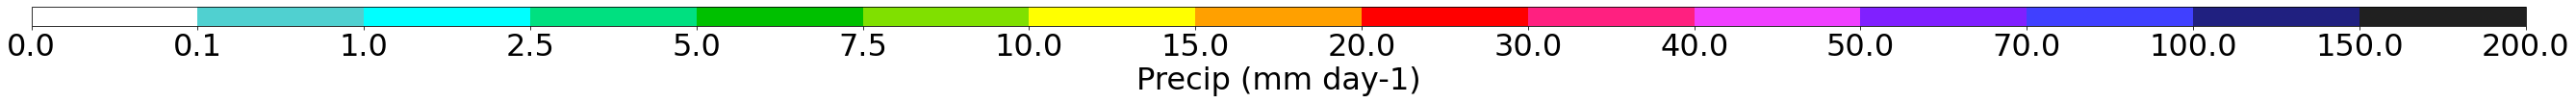

STV Shuffled Fix CP 10

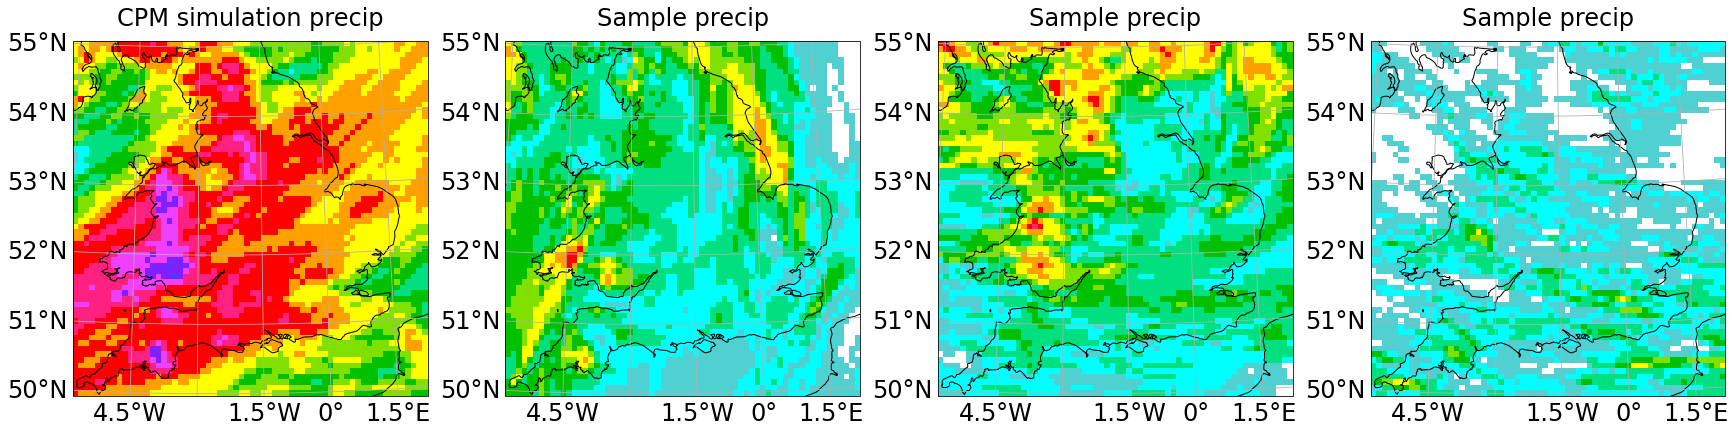

STV Shuffled Fix CP 15

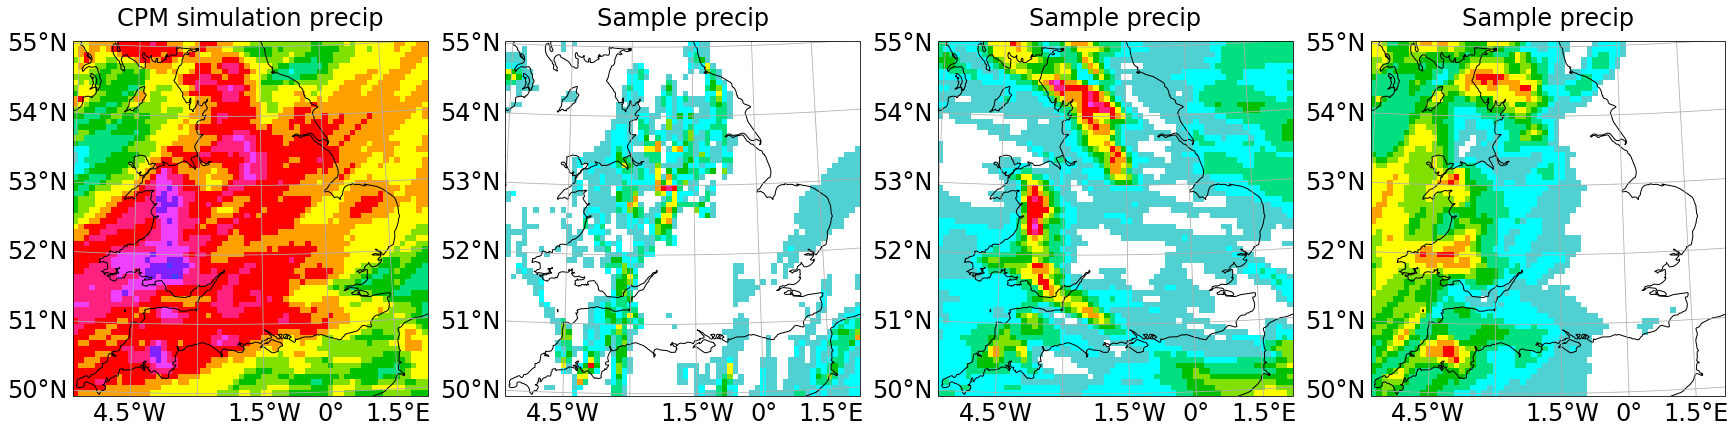

STV Shuffled Fix CP 20

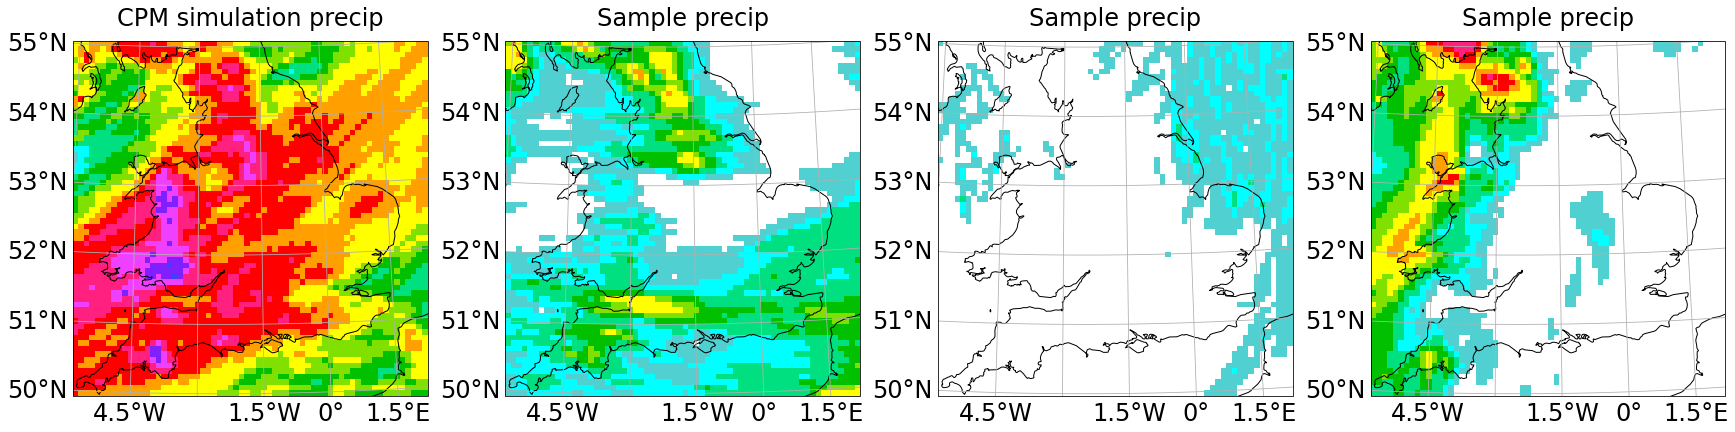

STV Shuffled Fix CP 5

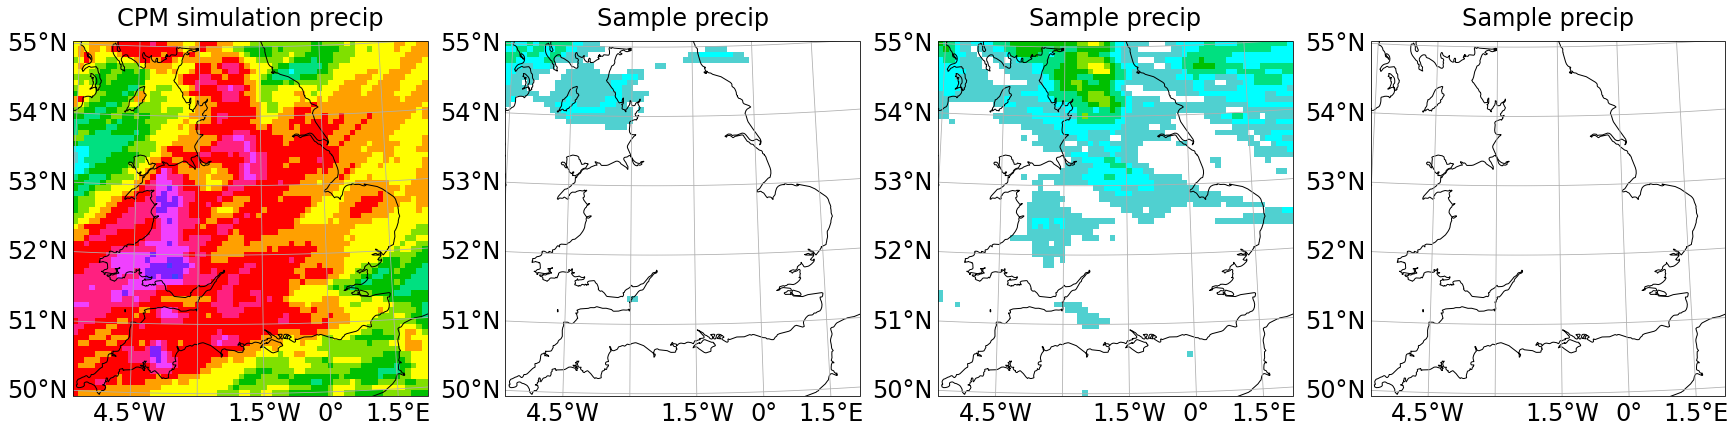

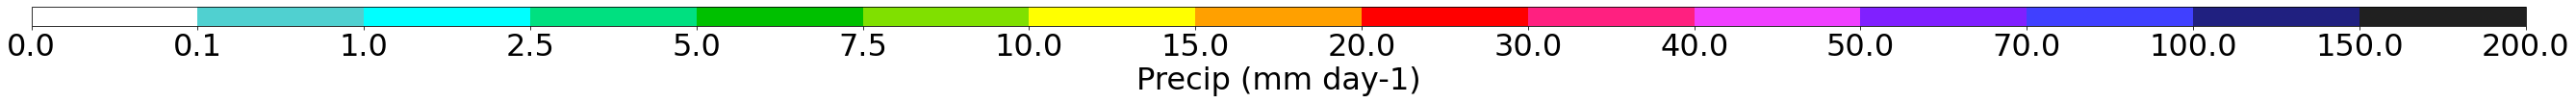

STV Shuffled Fix CP 10

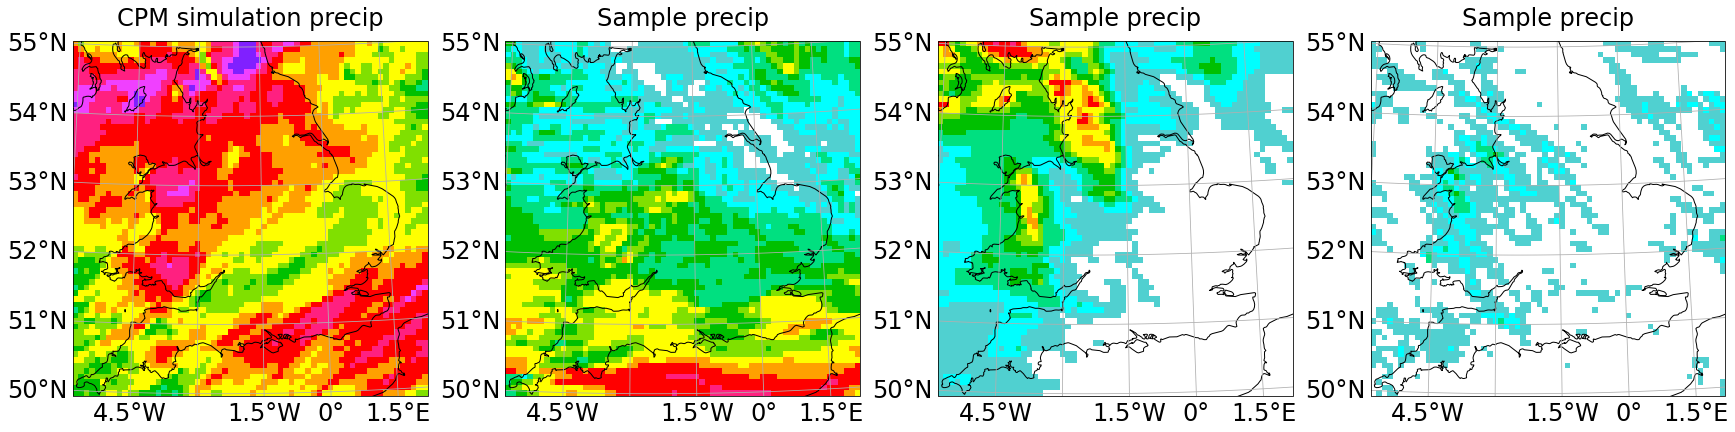

STV Shuffled Fix CP 15

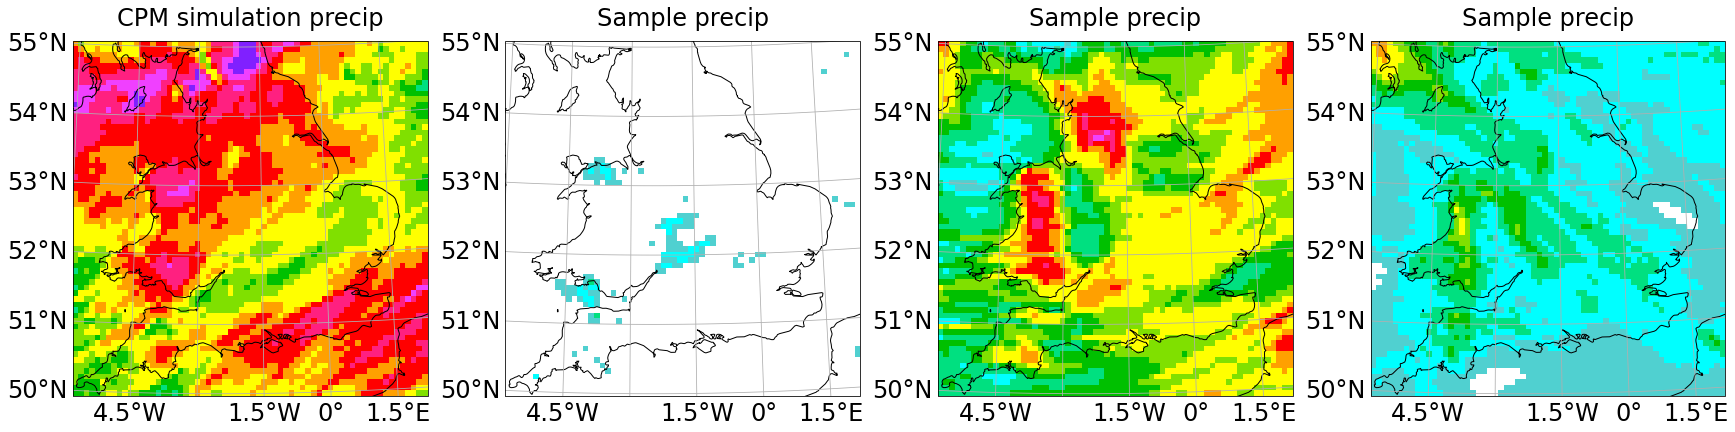

STV Shuffled Fix CP 20

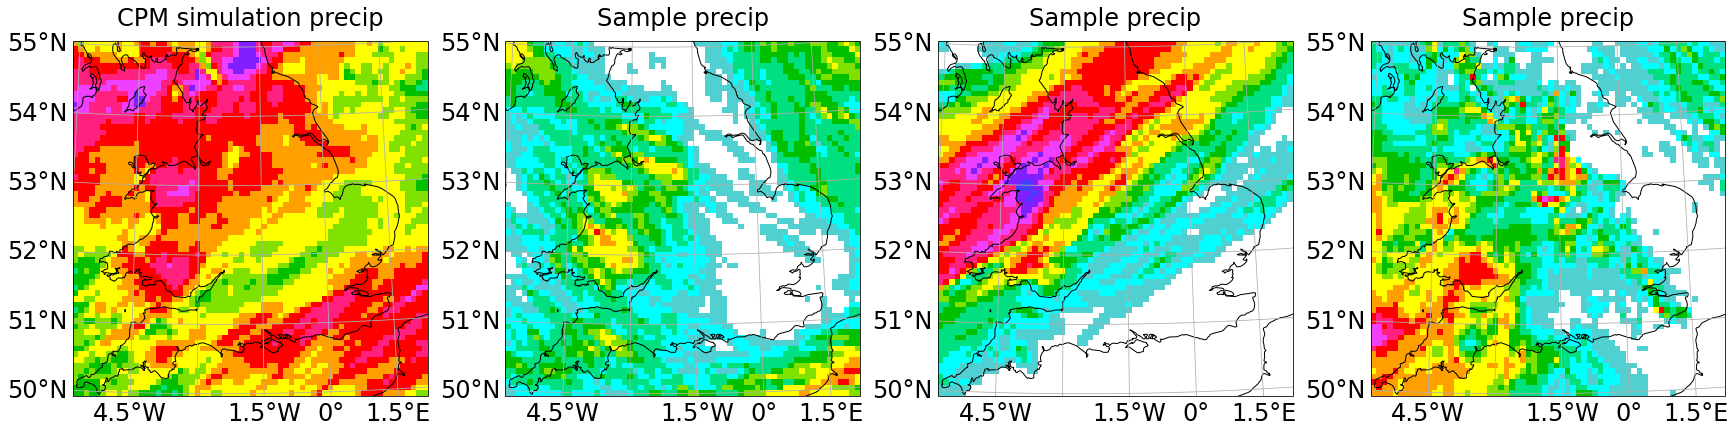

STV Shuffled Fix CP 5

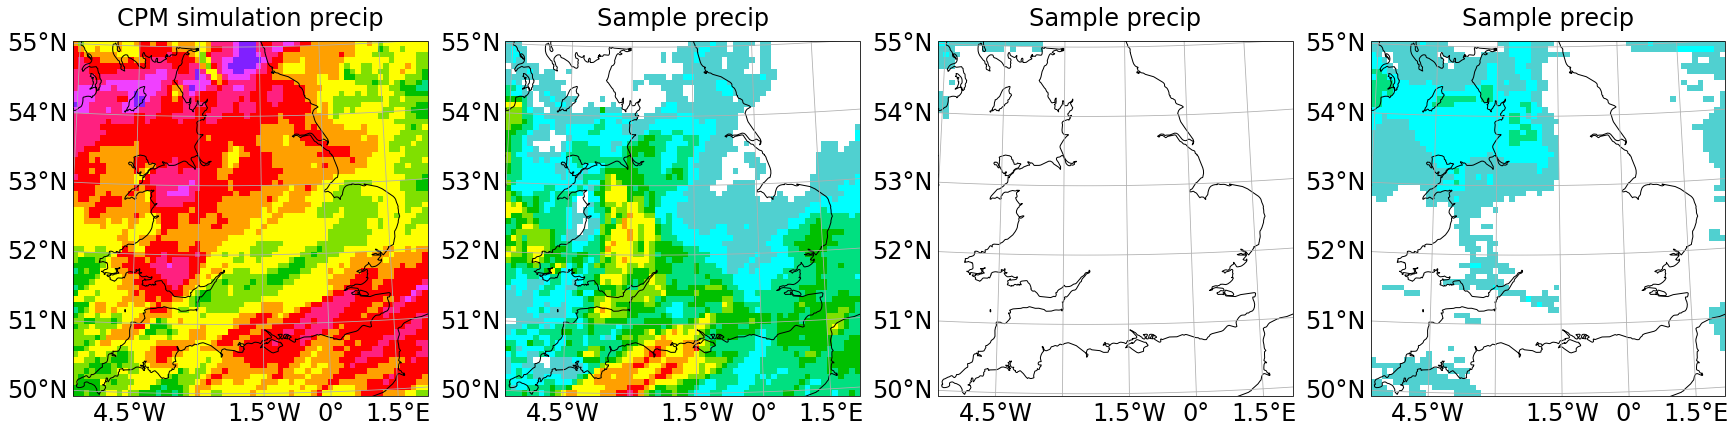

Timestep chunk 1

CPM

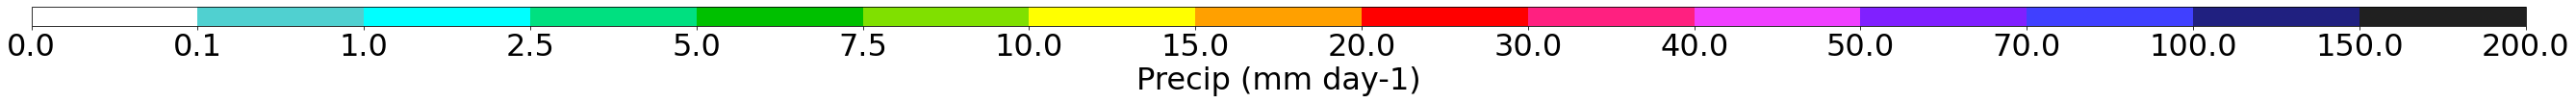

STV Shuffled Fix CP 10

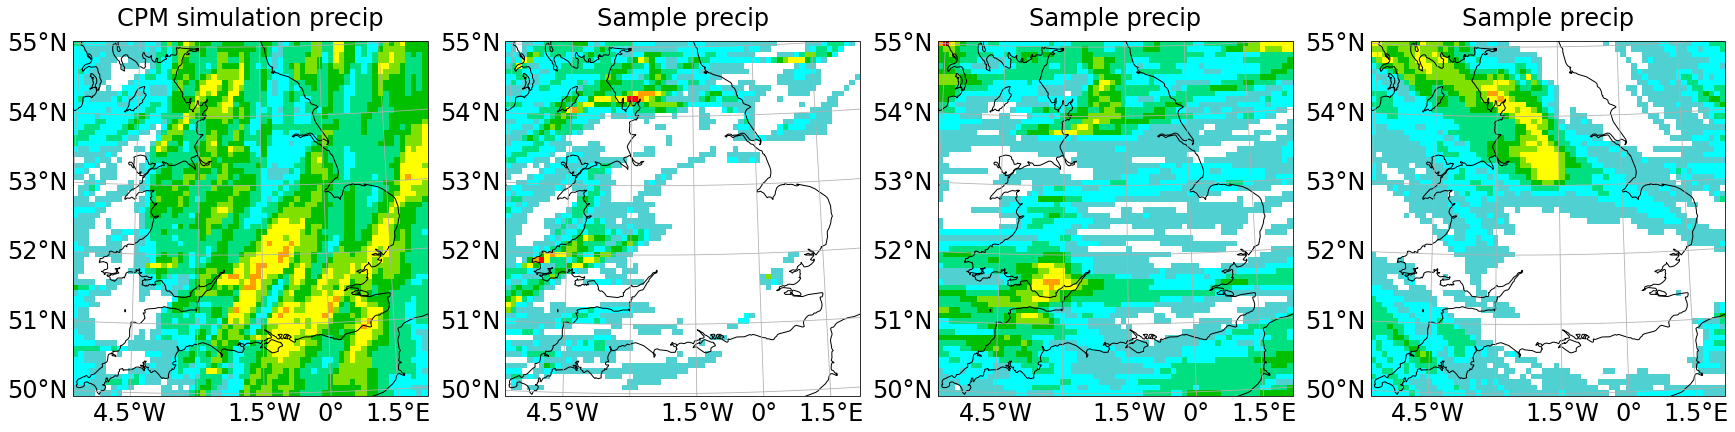

STV Shuffled Fix CP 15

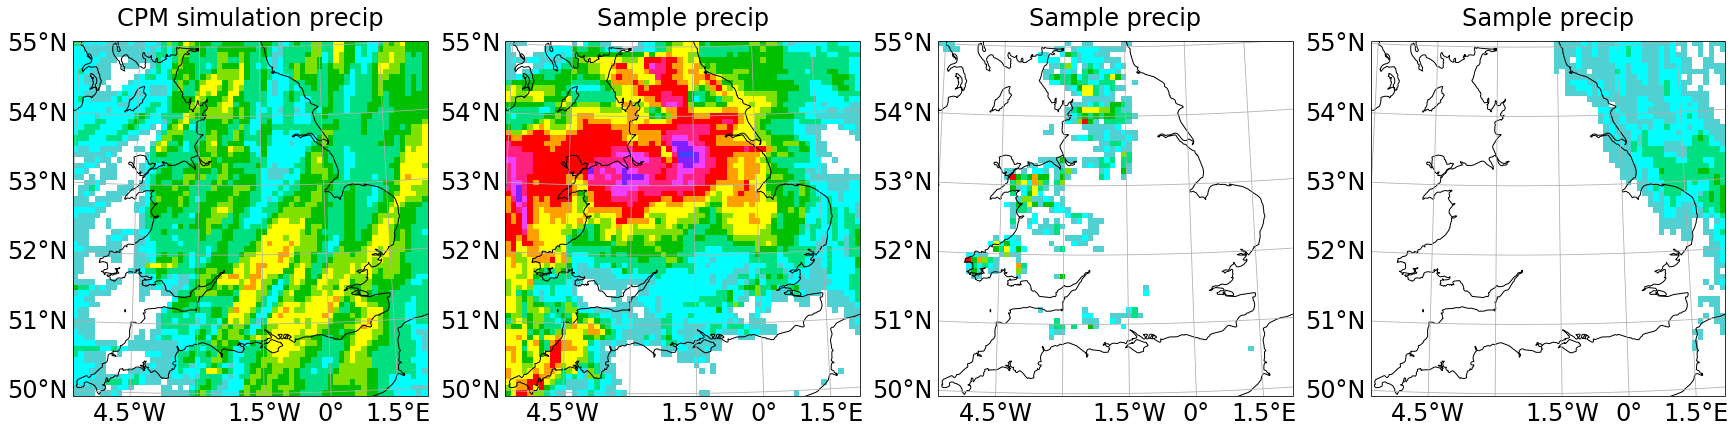

STV Shuffled Fix CP 20

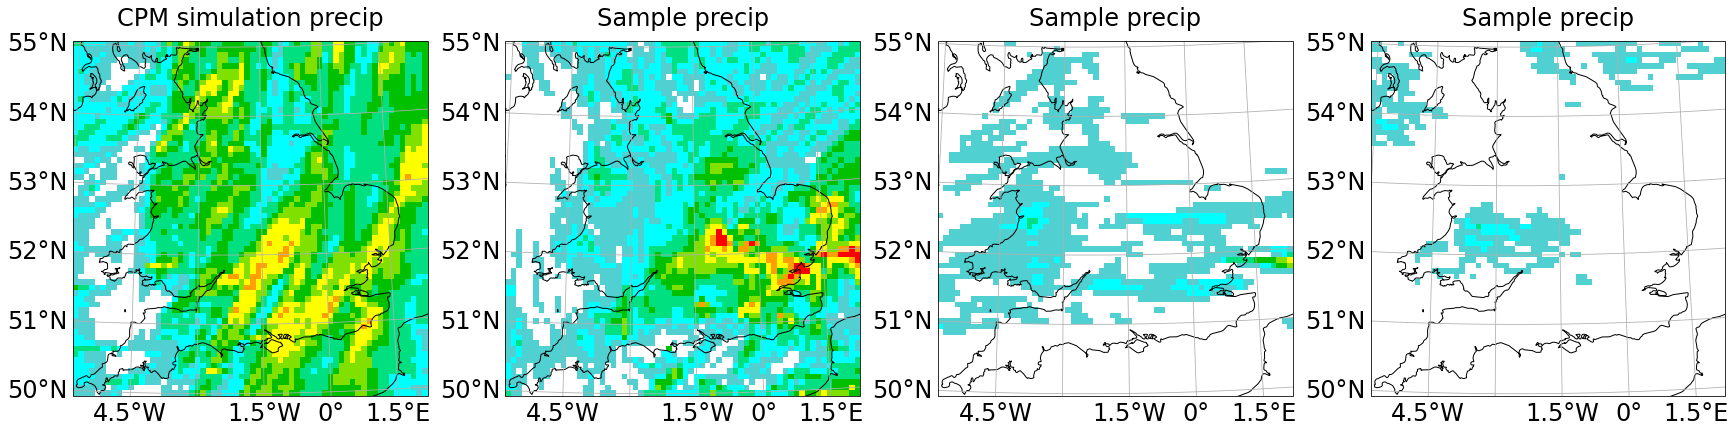

STV Shuffled Fix CP 5

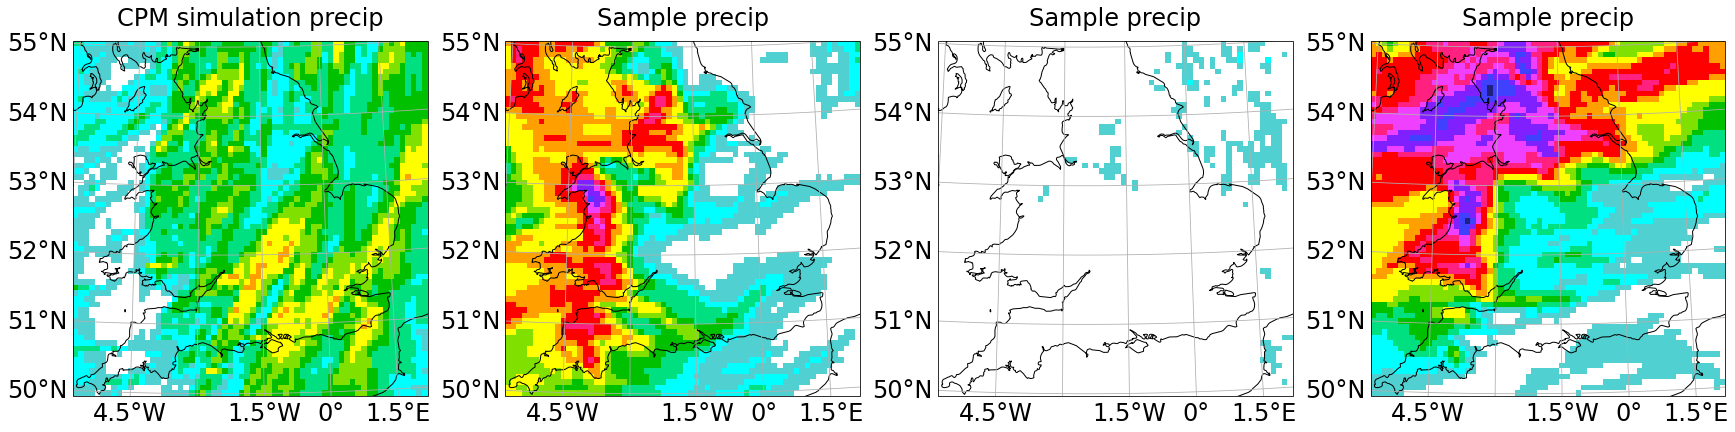

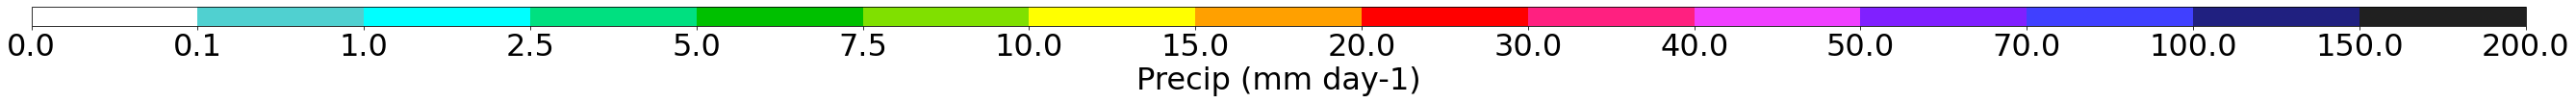

STV Shuffled Fix CP 10

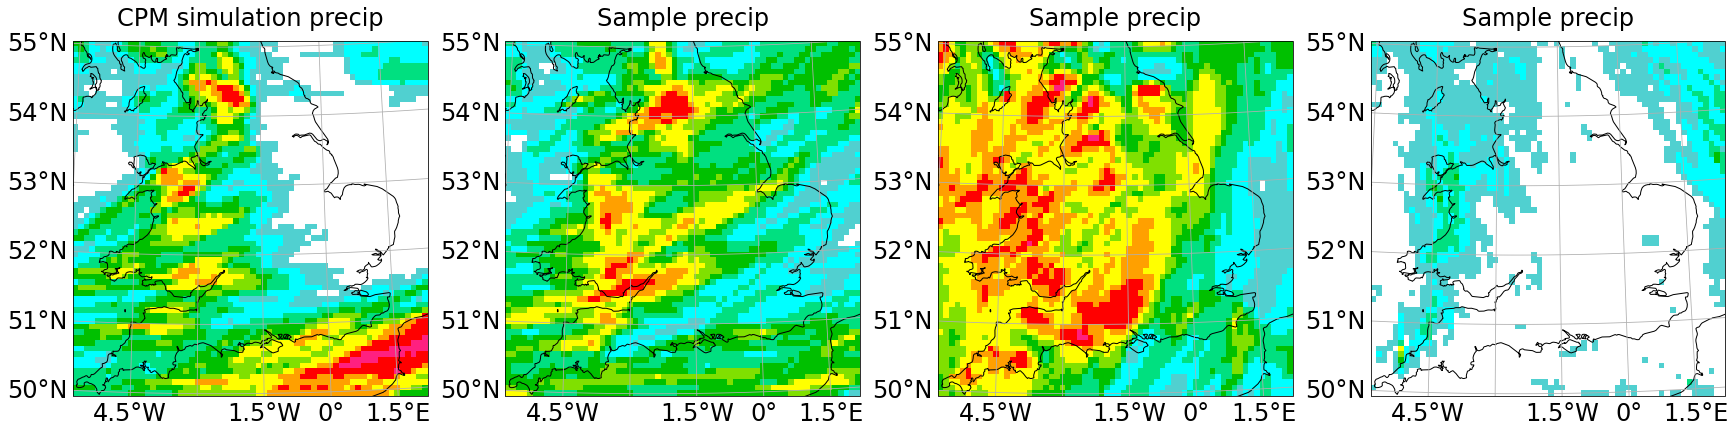

STV Shuffled Fix CP 15

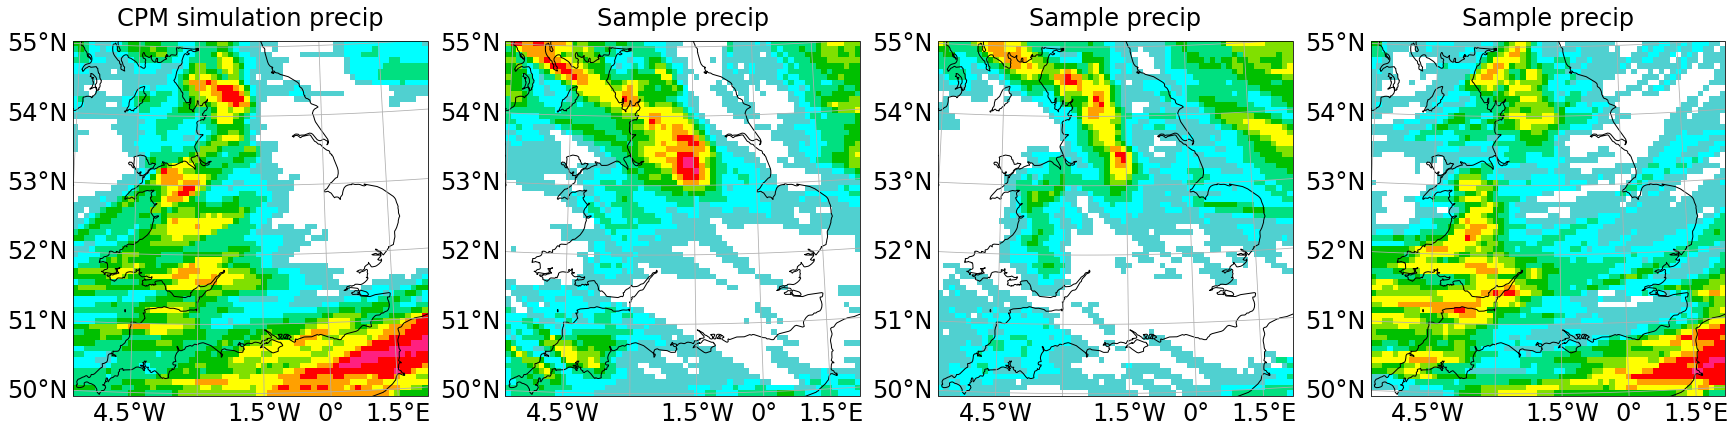

STV Shuffled Fix CP 20

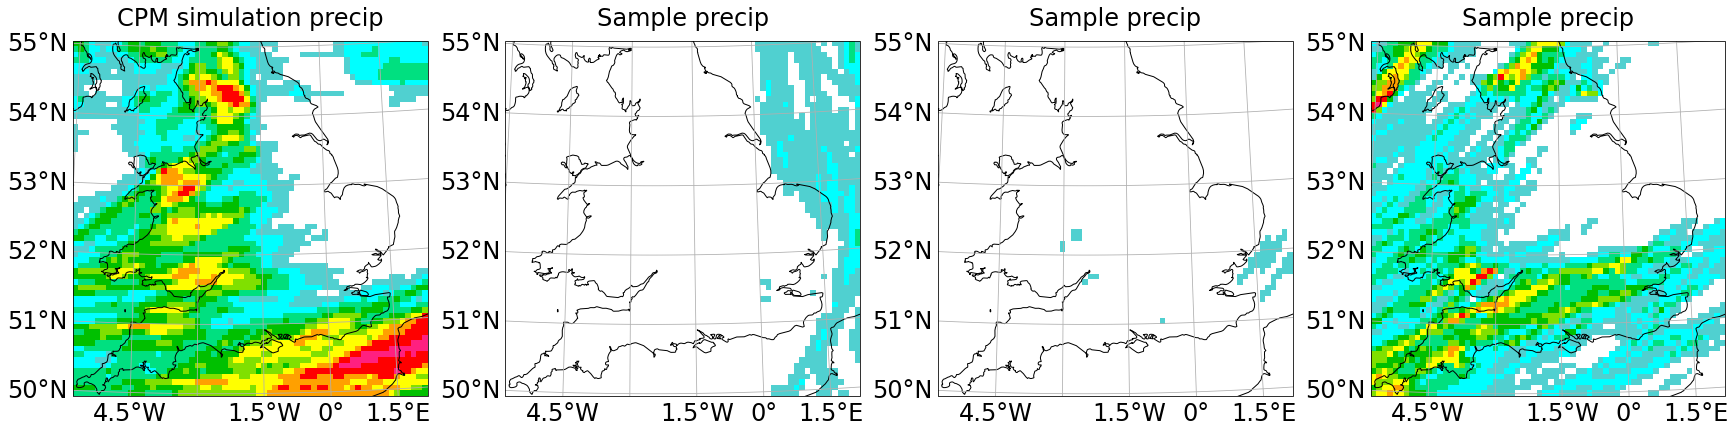

STV Shuffled Fix CP 5

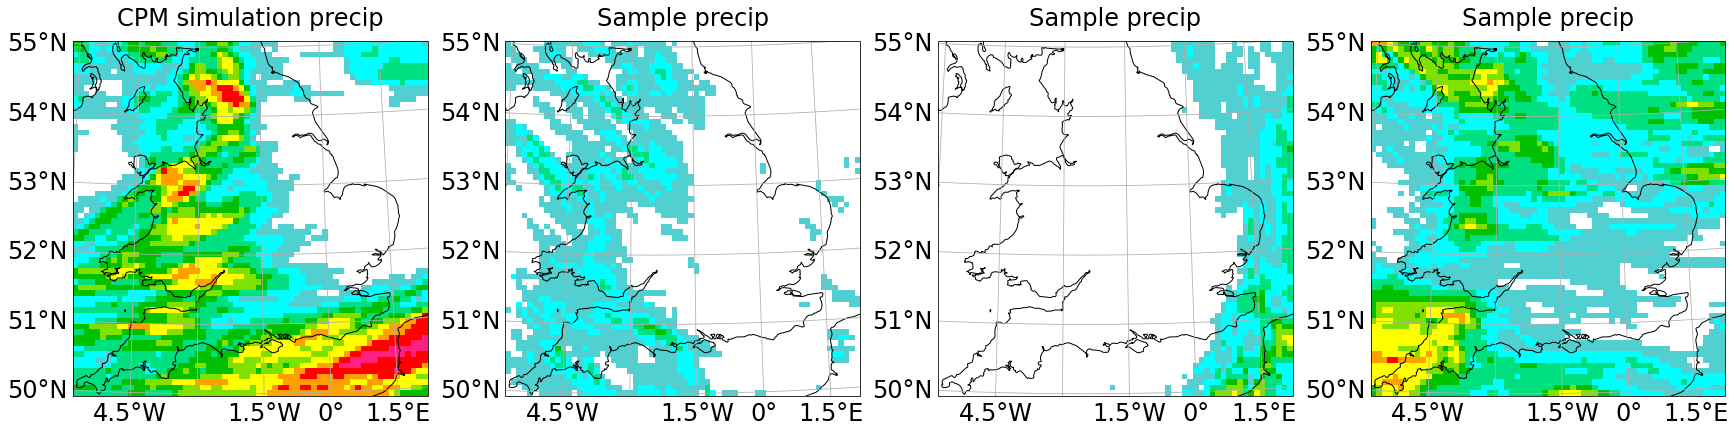

In [7]:
timestamp_chunks = [
    sorted_time[t:t+2] for t in [
        -20, 
        # math.ceil(len(sorted_time)*0.9),
        math.ceil(len(sorted_time)*0.81),
        # math.ceil(len(sorted_time)*0.5), 
        # 17
    ]
]
# timestamps = np.random.choice(sorted_time, size=2*3, replace=False)

for i, timestamps in enumerate(timestamp_chunks):
    IPython.display.display_html(f"<h1>Timestep chunk {i}</h1>", raw=True)
    show_samples(merged_ds, timestamps)

## Frequency distribution

### Pixel

CPM

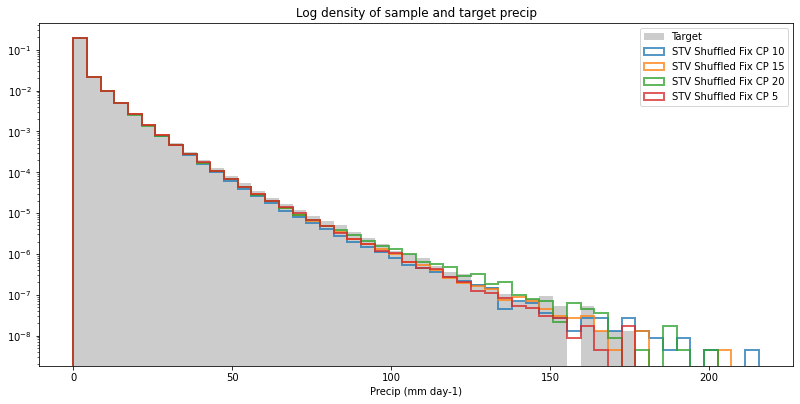

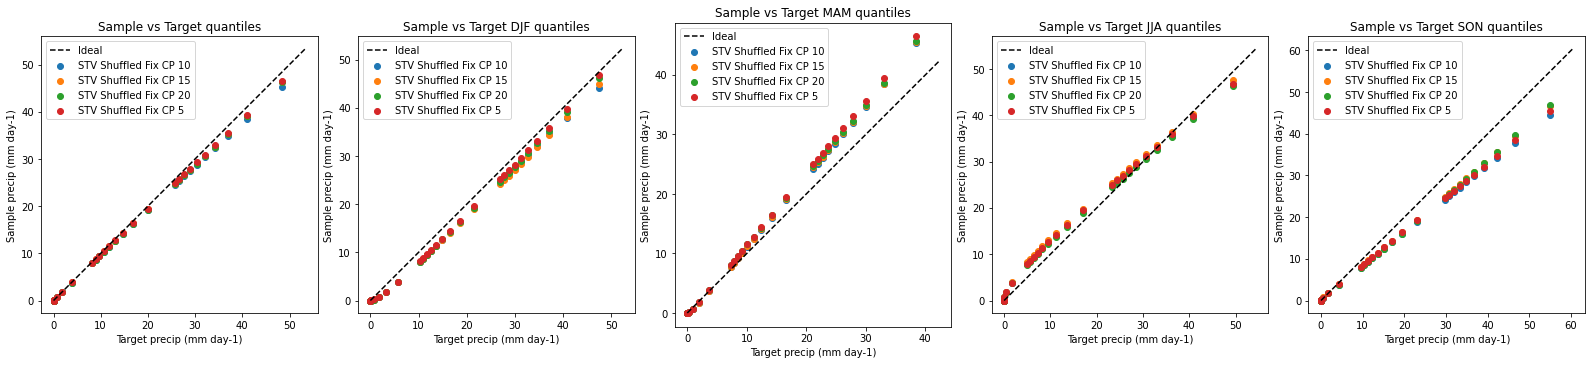

In [8]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.99,10), np.linspace(0.991,0.999,9)])

distribution_figure(merged_ds, quantiles, "Distribution of pixel values")

### Mean over space

CPM

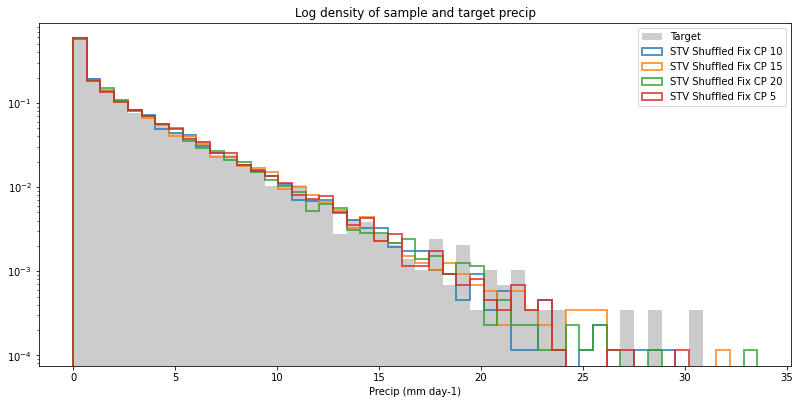

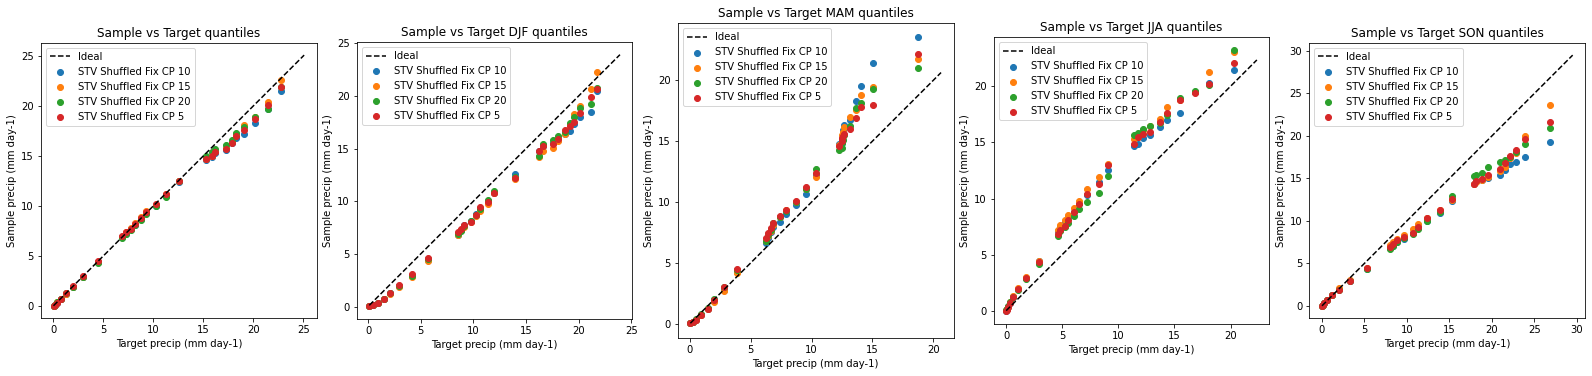

In [9]:
quantiles = np.concatenate([np.linspace(0.1,0.8,8), np.linspace(0.9,0.99,10), np.linspace(0.991,0.999,9)])

distribution_figure(merged_ds[["target_pr", "pred_pr"]].mean(dim=["grid_longitude", "grid_latitude"]), quantiles, "Distribution of mean precip over space")

## Bias

Bias/Target mean

All

CPM

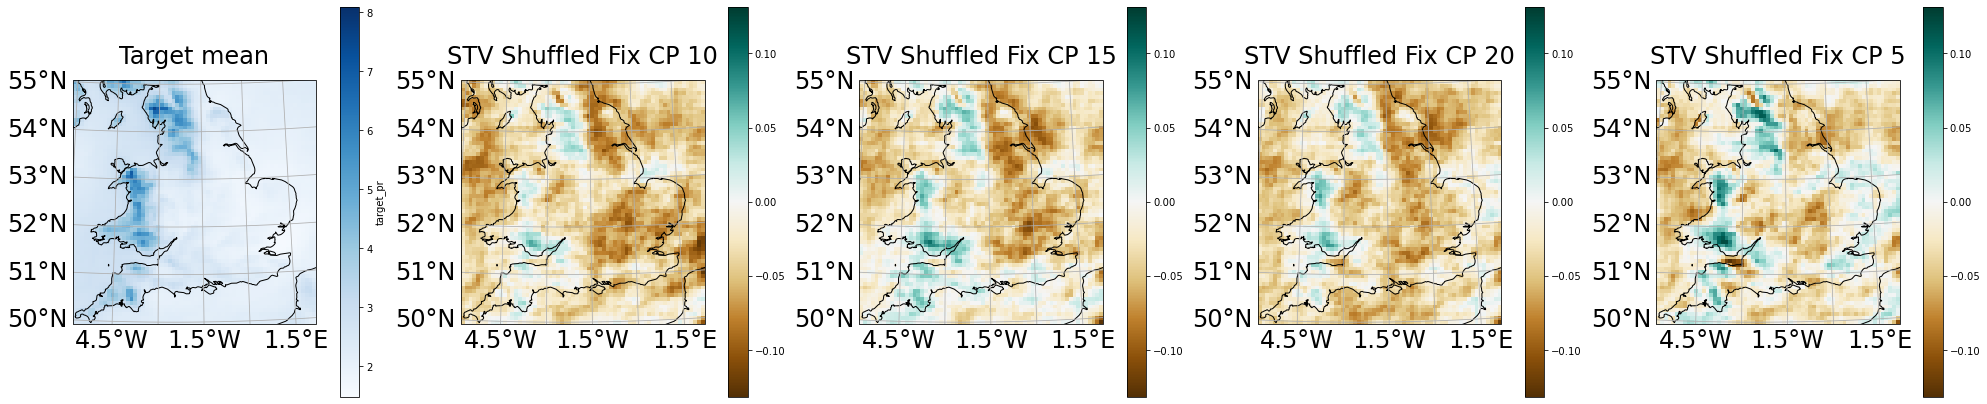

Season DJF

CPM

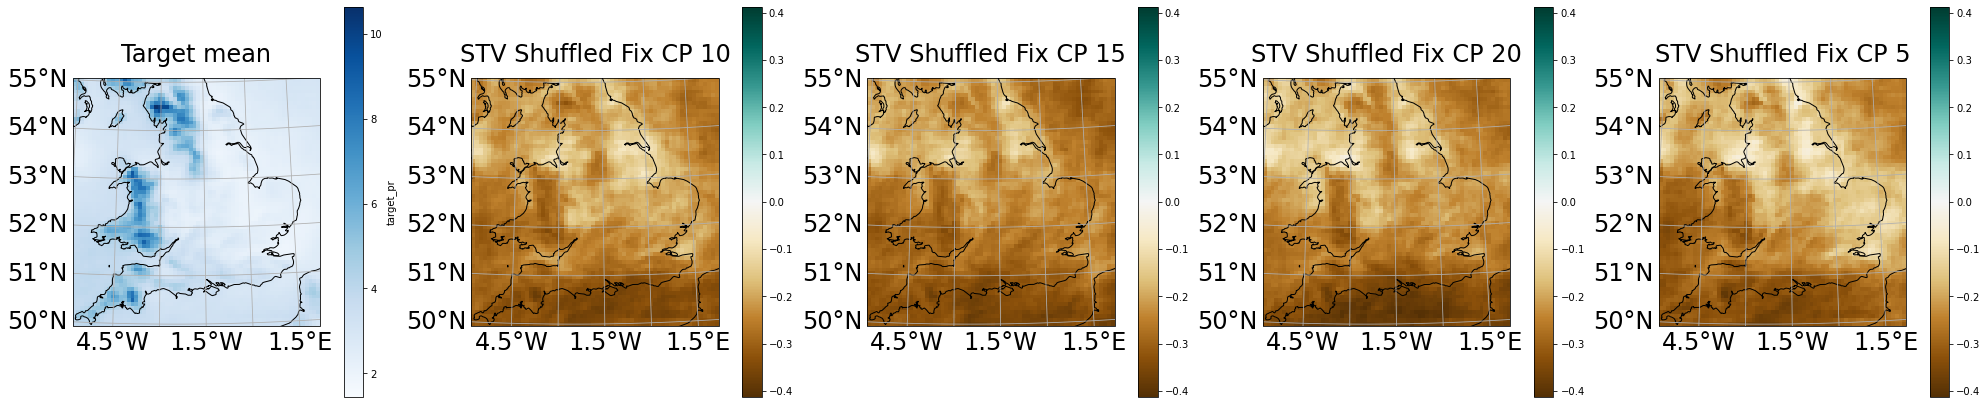

Season JJA

CPM

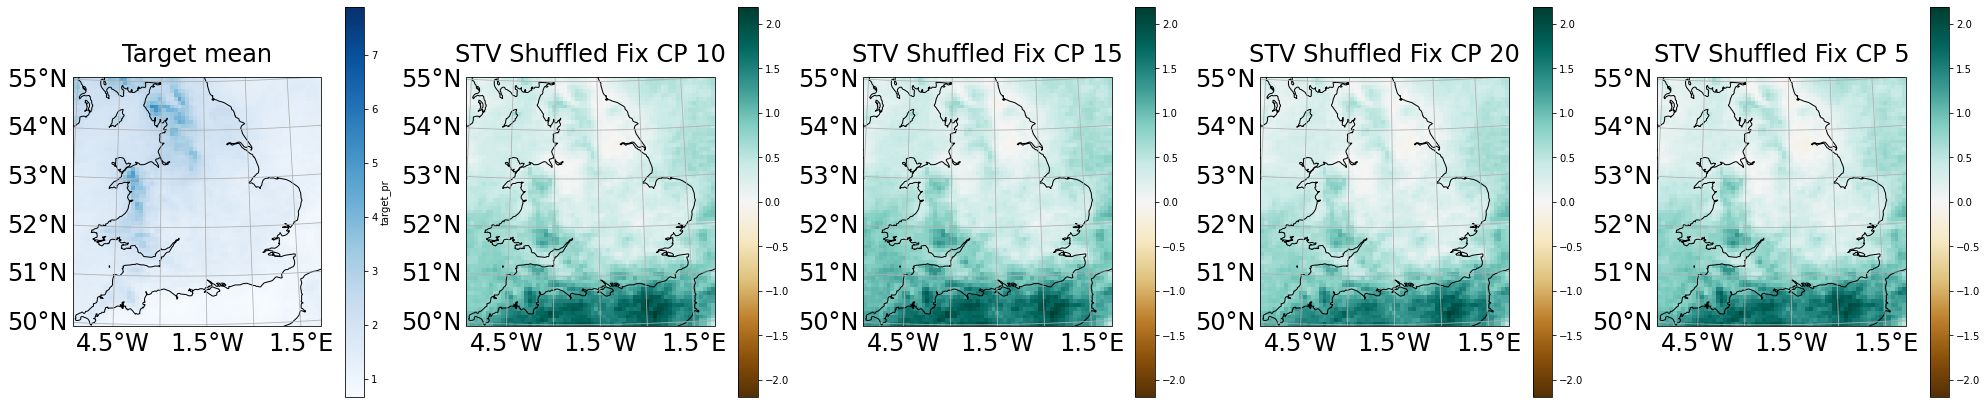

Season MAM

CPM

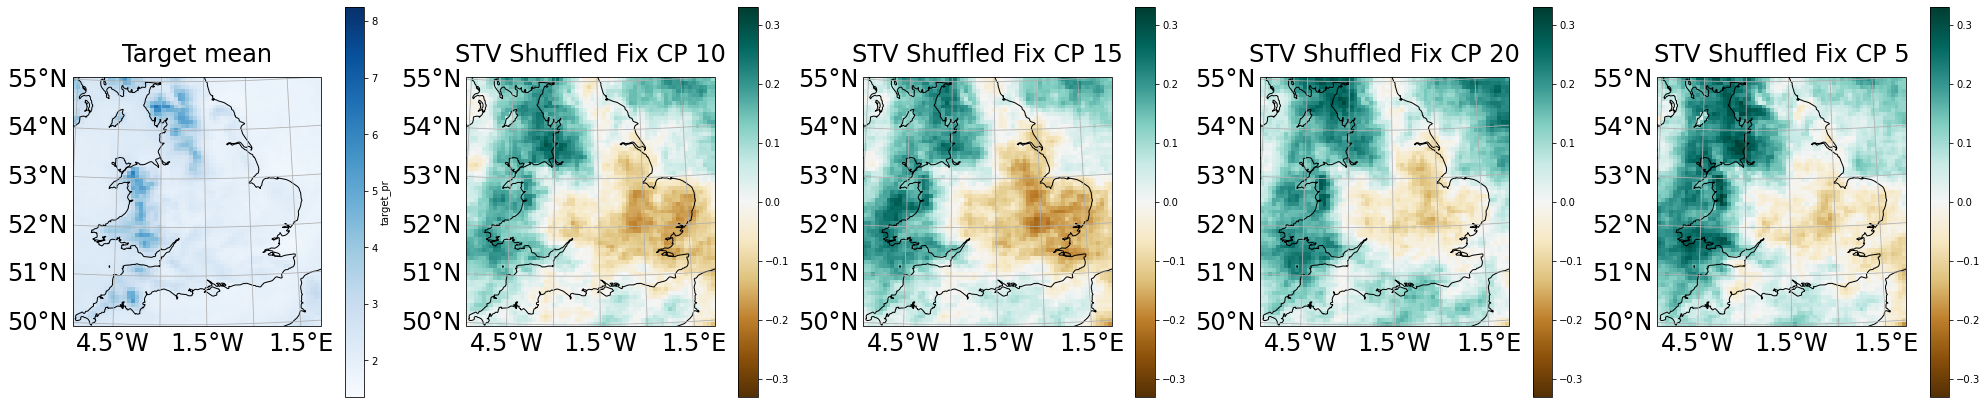

Season SON

CPM

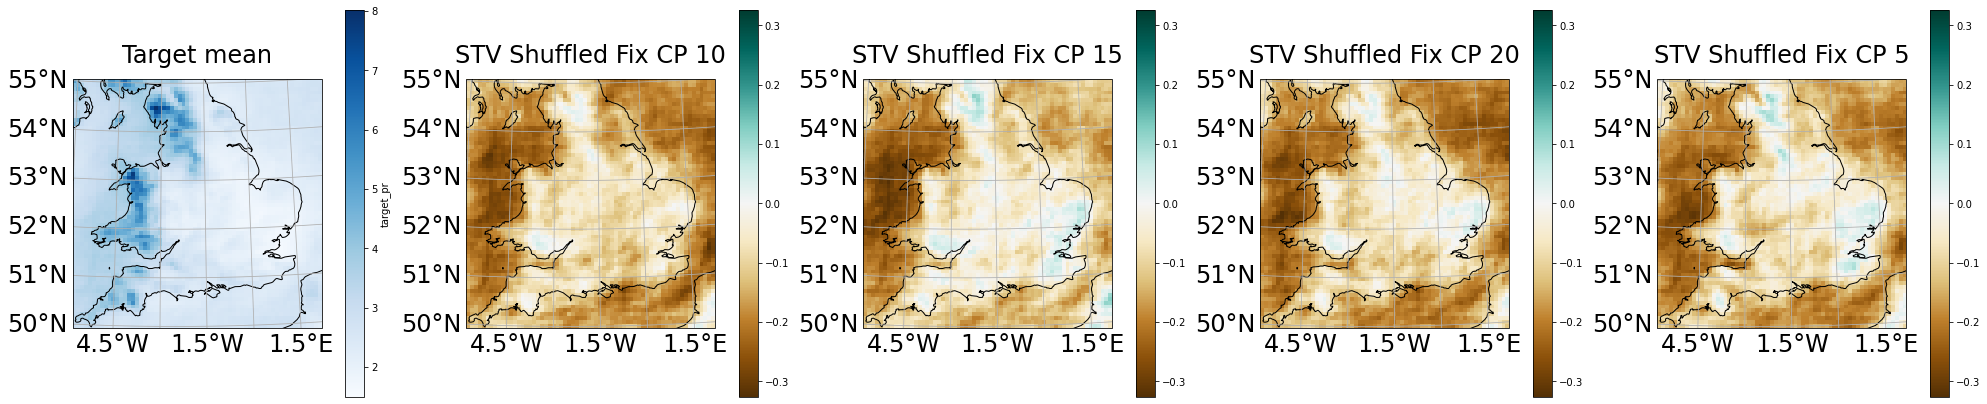

In [10]:
plot_mean_bias(merged_ds)

## Standard deviation

CPM

STV Shuffled Fix CP 10

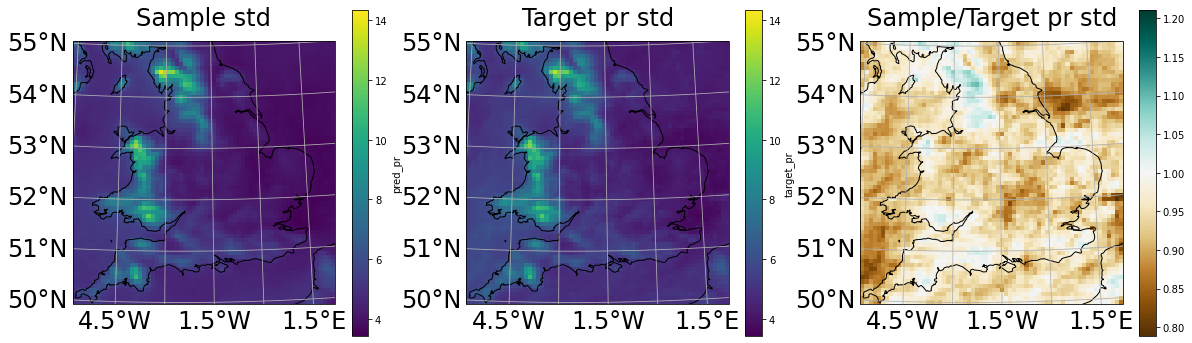

STV Shuffled Fix CP 15

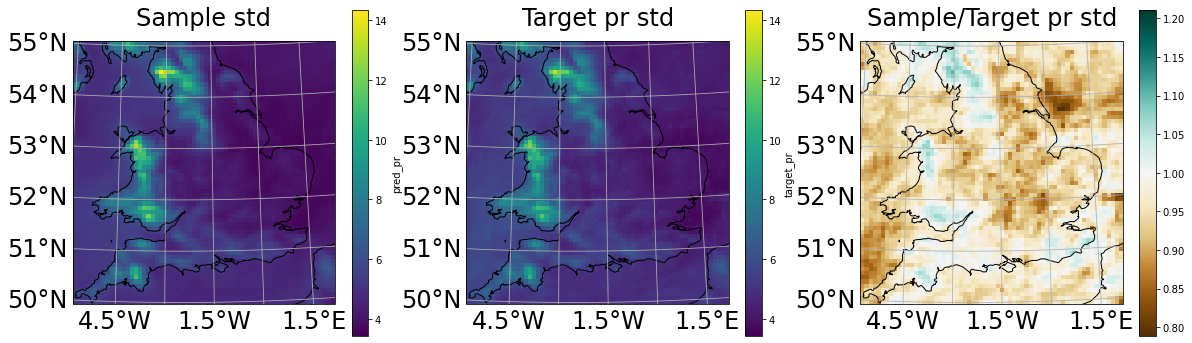

STV Shuffled Fix CP 20

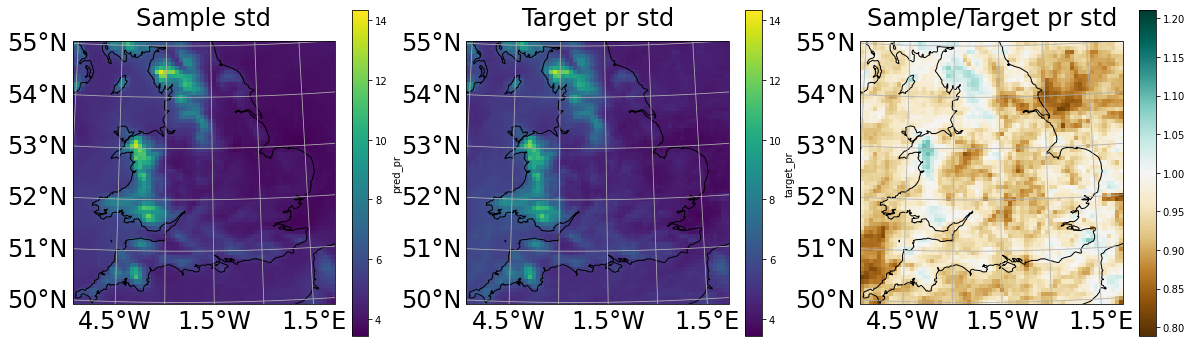

STV Shuffled Fix CP 5

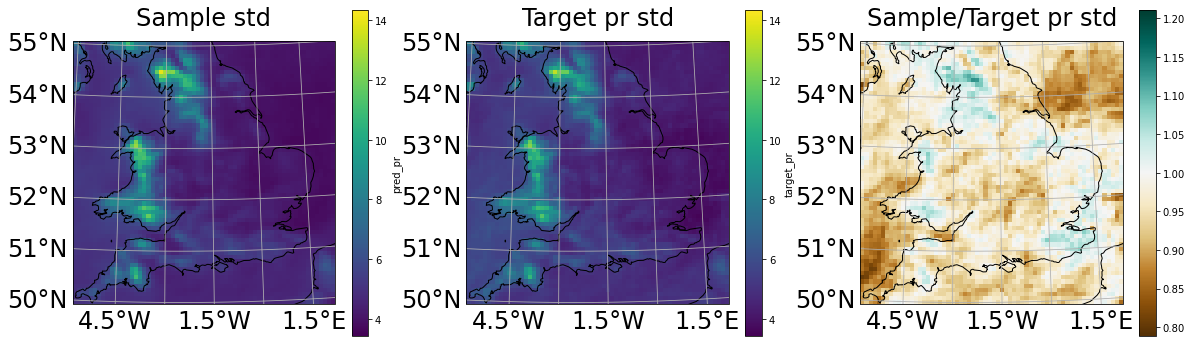

In [11]:
plot_std(merged_ds)

## Scatter

In [12]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())


# ax = axs

# ax.scatter(x=merged_ds["pred_pr"], y=merged_ds["target_pr"].values[None, :].repeat(len(merged_ds["sample_id"]), 0), alpha=0.05)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')


In [13]:
# sample_ids = np.arange(9).reshape(3, 3)

# fig, axs = plt.subplots(sample_ids.shape[0], sample_ids.shape[1], figsize=(30, 12))

# tr = min(merged_ds["pred_pr"].max(), merged_ds["target_pr"].max())

# for i, sample_id in enumerate(sample_ids.flatten()):
#     ax = axs[i//3][i%3]

#     ax.scatter(x=merged_ds["pred_pr"].sel(sample_id=sample_id), y=merged_ds["target_pr"], alpha=0.1)
#     ax.plot([0, tr], [0, tr], linewidth=1, color='green')
#     ax.set_xlabel(f"Sample {sample_id} pr")
#     ax.set_ylabel(f"Target pr")
    
# plt.show()

In [14]:
# fig, axs = plt.subplots(1, 1, figsize=(20, 6))

# tr = min(total_pred_pr.max(), total_target_pr.max())

# ax = axs

# ax.scatter(x=total_pred_pr, y=total_target_pr.values[None, :].repeat(len(total_pred_pr["sample_id"]), 0), alpha=0.25)
# ax.plot([0, tr], [0, tr], linewidth=1, color='green')

# plt.show()

## PSD

## Correlation